In [1]:
import os
import sys
import time
import shutil
import pickle

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.metrics import f1_score
from tensorflow import keras

import sklearn.preprocessing

In [2]:
def get_dataset(directory):    
    merged_df = pd.DataFrame()
    for files in os.listdir(directory):
        df = pd.read_csv(os.path.join(directory, files), index_col='timestamp')
        df.dropna(inplace=True)
        merged_df = pd.concat([merged_df, df], ignore_index=True)
    
    return merged_df

In [3]:
def convert_time_window(data, timesteps):
    samples = data.shape[0] - timesteps + 1  # Number of samples in the new 3D array
    variables = data.shape[1]  # Number of variables (features)

    data_3d = np.zeros((samples, timesteps, variables))

    for i in range(samples):
        data_3d[i] = data[i:i+timesteps]
    return data_3d

In [4]:
def inverse_convert_time_window(data_3d):
    samples, timesteps, variables = data_3d.shape
    data_2d = np.zeros((samples + timesteps - 1, variables))

    count = np.zeros((samples + timesteps - 1, variables))

    for i in range(samples):
        data_2d[i:i+timesteps] += data_3d[i]
        count[i:i+timesteps] += 1

    data_2d /= count
    return data_2d

In [5]:
def calculate_reconstruction_loss(data, reconstructions):
    reconstruction_errors = np.mean(np.abs(data - reconstructions), axis=1)
    return reconstruction_errors

In [48]:
def find_optimal_threshold(reconstruction_errors, y_true):
    best_threshold = 0.0
    best_f1 = 0.0

    thresholds = np.linspace(0.0, 2.0, num=1000)

    for threshold in thresholds:
        y_pred = (reconstruction_errors < threshold).astype(bool)

        current_f1 = f1_score(y_true.astype(bool), y_pred)

        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold

    return best_threshold, best_f1

In [7]:
merged_df = get_dataset('dataset_processed/splitted/2/train')
merged_data_class = merged_df['class']

merged_data_np = merged_df.drop('class', axis=1).values

In [8]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(merged_data_np)

merged_data_np_scaled = scaler.transform(merged_data_np)

pickle.dump(scaler, open('StandardScaler.pkl', 'wb'))

In [9]:
window_size = 30
merged_data_np_3d = convert_time_window(merged_data_np_scaled, window_size)

In [10]:
merged_data_np_3d.shape

(536733, 30, 3)

In [11]:
def build_encoder_layer(input_shape, encoder_reshape_shape):    
    input_layer = keras.layers.Input(shape=input_shape)    
    x = keras.layers.Bidirectional(keras.layers.LSTM(units=100, return_sequences=True))(input_layer)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(encoder_reshape_shape[0] * encoder_reshape_shape[1])(x)
    x = keras.layers.Reshape(target_shape=encoder_reshape_shape)(x)
    model = keras.models.Model(input_layer, x, name='encoder')

    return model

def build_generator_layer(input_shape, generator_reshape_shape):
    input_layer = keras.layers.Input(shape=input_shape)    
    x = keras.layers.Flatten()(input_layer)
    x = keras.layers.Dense(generator_reshape_shape[0] * generator_reshape_shape[1])(x)
    x = keras.layers.Reshape(target_shape=generator_reshape_shape)(x)
    x = keras.layers.Bidirectional(keras.layers.LSTM(units=64, return_sequences=True), merge_mode='concat')(x)
    x = keras.layers.UpSampling1D(size=2)(x)
    x = keras.layers.Bidirectional(keras.layers.LSTM(units=64, return_sequences=True), merge_mode='concat')(x)
    x = keras.layers.TimeDistributed(keras.layers.Dense(generator_reshape_shape[1]))(x)
    x = keras.layers.Activation(activation='tanh')(x)
    model = keras.models.Model(input_layer, x, name='generator')   

    return model

def build_critic_x_layer(input_shape):
    input_layer = keras.layers.Input(shape=input_shape)
    x = keras.layers.Conv1D(filters=64, kernel_size=5)(input_layer)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)
    x = keras.layers.Dropout(rate=0.25)(x)
    x = keras.layers.Conv1D(filters=64, kernel_size=5)(x)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)
    x = keras.layers.Dropout(rate=0.25)(x)
    x = keras.layers.Conv1D(filters=64, kernel_size=5)(x)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)
    x = keras.layers.Dropout(rate=0.25)(x)
    x = keras.layers.Conv1D(filters=64, kernel_size=5)(x)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)
    x = keras.layers.Dropout(rate=0.25)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(units=1)(x)
    model = keras.models.Model(input_layer, x, name='critic_x')

    return model 


def build_critic_z_layer(input_shape):
    input_layer = keras.layers.Input(shape=input_shape)
    x = keras.layers.Flatten()(input_layer)
    x = keras.layers.Dense(units=100)(x)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)
    x = keras.layers.Dropout(rate=0.2)(x)    
    x = keras.layers.Dense(units=100)(x)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)
    x = keras.layers.Dropout(rate=0.2)(x)  
    x = keras.layers.Dense(units=1)(x)
    model = keras.models.Model(input_layer, x, name='critic_z')
    
    return model

In [12]:
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)
    # return K.mean(y_true * y_pred)

In [13]:
features = 3
latent_dim = 10
shape = (window_size, features)

In [14]:
# Layer Parameters
encoder_input_shape = (window_size, features)
generator_input_shape = (latent_dim, features)

critic_x_input_shape = (window_size, features)
critic_z_input_shape = (latent_dim,features)

encoder_reshape_shape = (latent_dim, features)
generator_reshape_shape = (window_size//2, features) # window_size//3 <- 3 is Upsampling size

learning_rate = 0.001

# Build Model
encoder = build_encoder_layer(input_shape=encoder_input_shape, encoder_reshape_shape=encoder_reshape_shape)

generator = build_generator_layer(input_shape=generator_input_shape, generator_reshape_shape=generator_reshape_shape)

critic_x = build_critic_x_layer(input_shape=critic_x_input_shape)
critic_z = build_critic_z_layer(input_shape=critic_z_input_shape)

encoder_optimizer = tf.keras.optimizers.Adam(learning_rate)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate)
critic_x_optimizer = tf.keras.optimizers.Adam(learning_rate)
critic_z_optimizer = tf.keras.optimizers.Adam(learning_rate)

In [15]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 3)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 30, 200)          83200     
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 6000)              0         
                                                                 
 dense (Dense)               (None, 30)                180030    
                                                                 
 reshape (Reshape)           (None, 10, 3)             0         
                                                                 
Total params: 263,230
Trainable params: 263,230
Non-trainable params: 0
_____________________________________________________

In [16]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 3)]           0         
                                                                 
 flatten_1 (Flatten)         (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 45)                1395      
                                                                 
 reshape_1 (Reshape)         (None, 15, 3)             0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 15, 128)          34816     
 nal)                                                            
                                                                 
 up_sampling1d (UpSampling1D  (None, 30, 128)          0         
 )                                                       

In [17]:
critic_x.summary()

Model: "critic_x"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 3)]           0         
                                                                 
 conv1d (Conv1D)             (None, 26, 64)            1024      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 26, 64)            0         
                                                                 
 dropout (Dropout)           (None, 26, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 64)            20544     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 22, 64)            0         
                                                                 
 dropout_1 (Dropout)         (None, 22, 64)            0  

In [18]:
critic_z.summary()

Model: "critic_z"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 10, 3)]           0         
                                                                 
 flatten_3 (Flatten)         (None, 30)                0         
                                                                 
 dense_4 (Dense)             (None, 100)               3100      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 100)               0         
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 100)               0  

In [19]:
batch_size = 32

In [21]:
@tf.function
def critic_x_train_on_batch(x, z):
    with tf.GradientTape() as tape:

        x = tf.cast(x, tf.float32)
        z = tf.cast(z, tf.float32)
        
        valid_x = critic_x(x)
        x_ = generator(z)
        fake_x = critic_x(x_)
        
        # Interpolated 
        alpha = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0)
        interpolated = alpha * x + (1 - alpha) * x_ 
        
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = critic_x(interpolated)
        
        grads = gp_tape.gradient(pred, interpolated)
        grad_norm = tf.norm(tf.reshape(grads, (batch_size, -1)), axis=1)
        gp_loss = 10.0*tf.reduce_mean(tf.square(grad_norm - 1.))
#         grads = tf.square(grads)
#         ddx = tf.sqrt(tf.reduce_sum(grads, axis=np.arange(1, len(grads.shape))))
#        gp_loss = tf.reduce_mean((1.0 - ddx) ** 2)
                
        loss1 = wasserstein_loss(-tf.ones_like(valid_x), valid_x)
        loss2 = wasserstein_loss(tf.ones_like(fake_x), fake_x)
        #loss = tf.add_n([loss1, loss2, gp_loss*10.0])        
        loss = loss1 + loss2 + gp_loss
#        loss = tf.reduce_mean(loss)
                        
    gradients = tape.gradient(loss, critic_x.trainable_weights)
    critic_x_optimizer.apply_gradients(zip(gradients, critic_x.trainable_weights))
    return loss

In [22]:
@tf.function
def critic_z_train_on_batch(x, z):
    with tf.GradientTape() as tape:
        x = tf.cast(x, tf.float32)
        z = tf.cast(z, tf.float32)
        
        z_ = encoder(x)   
        valid_z = critic_z(z)             
        fake_z = critic_z(z_)
        
        # Interpolated 
        alpha = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0)
        interpolated = alpha * z + (1 - alpha) * z_ 
                
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = critic_z(interpolated, training=True)
            
        grads = gp_tape.gradient(pred, interpolated)
        grad_norm = tf.norm(tf.reshape(grads, (batch_size, -1)), axis=1)
        gp_loss = 10.0*tf.reduce_mean(tf.square(grad_norm - 1.))

#         grads = tf.square(grads)
#         ddx = tf.sqrt(tf.reduce_sum(grads, axis=np.arange(1, len(grads.shape))))
#         gp_loss = tf.reduce_mean((1.0 - ddx) ** 2)
        
        loss1 = wasserstein_loss(-tf.ones_like(valid_z), valid_z)
        loss2 = wasserstein_loss(tf.ones_like(fake_z), fake_z) # <- 이게 미친듯이 뜀. 
        loss = loss1 + loss2 + gp_loss
#        loss = tf.reduce_mean(loss)
        
    gradients = tape.gradient(loss, critic_z.trainable_weights)
    critic_z_optimizer.apply_gradients(zip(gradients, critic_z.trainable_weights))
    return loss

In [23]:
# @tf.function
# def enc_gen_train_on_batch(x, z):
#     with tf.GradientTape() as enc_tape, tf.GradientTape() as gen_tape:
#         x = tf.cast(x, tf.float32)
#         z = tf.cast(z, tf.float32)
        
#         z_gen_ = encoder(x, training=True)
#         x_gen_ = generator(z, training=True)        
#         x_gen_rec = generator(z_gen_, training=True)
        
#         fake_gen_x = critic_x(x_gen_, training=False)
#         fake_gen_z = critic_z(z_gen_, training=False)
        
#         loss1 = wasserstein_loss(fake_gen_x, -tf.ones_like(fake_gen_x))
#         loss2 = wasserstein_loss(fake_gen_z, -tf.ones_like(fake_gen_z))
#         loss3 = 10.0 * tf.reduce_mean(tf.keras.losses.MSE(x, x_gen_rec))

#         enc_loss = loss1 + loss2 + loss3
#         gen_loss = enc_loss  # They are tied together in TadGAN
        
#     gradients_encoder = enc_tape.gradient(enc_loss, encoder.trainable_weights)
#     encoder_optimizer.apply_gradients(zip(gradients_encoder, encoder.trainable_weights))

#     gradients_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)    
#     generator_optimizer.apply_gradients(zip(gradients_generator, generator.trainable_weights))    
#     return enc_loss, gen_loss


@tf.function
def enc_gen_train_on_batch(x, z):
    with tf.GradientTape() as enc_tape:
        z_gen_ = encoder(x, training=True)
        x_gen_ = generator(z, training=False)        
        x_gen_rec = generator(z_gen_, training=False)
        
        fake_gen_x = critic_x(x_gen_, training=False)
        fake_gen_z = critic_z(z_gen_, training=False)
        
        loss1 = wasserstein_loss(fake_gen_x, -tf.ones_like(fake_gen_x))
        loss2 = wasserstein_loss(fake_gen_z, -tf.ones_like(fake_gen_z))
        loss3 = 10.0*tf.reduce_mean(tf.keras.losses.MSE(x, x_gen_rec))

        enc_loss = loss1 + loss2 + loss3
        
    gradients_encoder = enc_tape.gradient(enc_loss, encoder.trainable_weights)
    encoder_optimizer.apply_gradients(zip(gradients_encoder, encoder.trainable_weights))

    with tf.GradientTape() as gen_tape:
        z_gen_ = encoder(x, training=False)
        x_gen_ = generator(z, training=True)        
        x_gen_rec = generator(z_gen_, training=True)
        
        fake_gen_x = critic_x(x_gen_, training=False)
        fake_gen_z = critic_z(z_gen_, training=False)
        
        loss1 = wasserstein_loss(fake_gen_x, -tf.ones_like(fake_gen_x))
        loss2 = wasserstein_loss(fake_gen_z, -tf.ones_like(fake_gen_z))
        loss3 = 10.0*tf.reduce_mean(tf.keras.losses.MSE(x, x_gen_rec))

        gen_loss = loss1 + loss2 + loss3
        
    gradients_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)    
    generator_optimizer.apply_gradients(zip(gradients_generator, generator.trainable_weights))    
    return enc_loss, gen_loss

In [24]:
# Train parameters
batch_size = 32
n_critics = 2
epochs = 10

In [25]:
merged_data_np_3d.shape

(536733, 30, 3)

In [26]:
# Data Reshape
X = merged_data_np_3d.reshape((-1, shape[0], shape[1]))
X_ = np.copy(X)

In [ ]:
# Modified callback function to handle separate models
def myCallbacks(log_dir, model_name):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=os.path.join(log_dir, model_name))
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='loss', 
        patience=5, 
        mode='min'
    )
    model_path = os.path.join(log_dir, f'best_{model_name}.h5')
    mc = tf.keras.callbacks.ModelCheckpoint(
        model_path, 
        monitor='loss', 
        mode='min', 
        verbose=1, 
        save_best_only=True
    )
    return [tensorboard_callback, early_stopping, mc]

In [27]:
# fake = np.ones((batch_size, 1), dtype=np.float32)
# valid = -np.ones((batch_size, 1), dtype=np.float32)
# delta = np.ones((batch_size, 1), dtype=np.float32)

epoch_e_loss = []    
epoch_g_loss = []
epoch_cx_loss = []
epoch_cz_loss = []

for epoch in range(1, epochs+1):
    
    np.random.shuffle(X_)
    
    minibatches_size = batch_size * n_critics  # 64*5 = 320 
    num_minibatches = int(X_.shape[0] // minibatches_size)  # 12 
    
    encoder.trainable = False
    generator.trainable = False
    
    for i in range(num_minibatches):
        minibatch = X_[i * minibatches_size: (i + 1) * minibatches_size]
                
        # Number of Critics 
        for j in range(n_critics):
            
            x = minibatch[j * batch_size: (j + 1) * batch_size]
            z = tf.random.normal(shape=(batch_size, latent_dim, features), mean=0.0, stddev=1, dtype=tf.dtypes.float32, seed=1748)
            
            critic_x.trainable = True
            critic_z.trainable = False
            epoch_cx_loss.append(critic_x_train_on_batch(x, z))
            critic_x.trainable = False
            critic_z.trainable = True
            epoch_cz_loss.append(critic_z_train_on_batch(x, z))
        
        critic_z.trainable = False
        critic_x.trainable = False
        encoder.trainable = True
        generator.trainable = True
        
        enc_loss, gen_loss = enc_gen_train_on_batch(x, z)
        epoch_e_loss.append(enc_loss)
        epoch_g_loss.append(gen_loss)
        
    cx_loss = np.mean(np.array(epoch_cx_loss), axis=0)
    cz_loss = np.mean(np.array(epoch_cz_loss), axis=0)
    e_loss = np.mean(np.array(epoch_e_loss), axis=0)
    g_loss = np.mean(np.array(epoch_g_loss), axis=0)
    
    print('Epoch: {}/{}, [Dx loss: {}] [Dz loss: {}] [E loss: {}] [G loss: {}]'.format(epoch, epochs, cx_loss, cz_loss, e_loss, g_loss))    

Epoch: 1/10, [Dx loss: -3.2160985469818115] [Dz loss: -1.802348256111145] [E loss: -12.808393478393555] [G loss: -13.0144681930542]
Epoch: 2/10, [Dx loss: -3.176670789718628] [Dz loss: -1.9472428560256958] [E loss: -10.544132232666016] [G loss: -10.697332382202148]
Epoch: 3/10, [Dx loss: -3.1635689735412598] [Dz loss: -1.8118988275527954] [E loss: -8.31566047668457] [G loss: -8.4513578414917]
Epoch: 4/10, [Dx loss: -3.157243490219116] [Dz loss: -1.7581053972244263] [E loss: -6.45909309387207] [G loss: -6.580051422119141]
Epoch: 5/10, [Dx loss: -3.1576571464538574] [Dz loss: -1.7273454666137695] [E loss: -5.53256368637085] [G loss: -5.644711971282959]
Epoch: 6/10, [Dx loss: -3.1549832820892334] [Dz loss: -1.612563133239746] [E loss: -5.062382221221924] [G loss: -5.164730548858643]
Epoch: 7/10, [Dx loss: -3.148851156234741] [Dz loss: -1.6479840278625488] [E loss: -4.1871337890625] [G loss: -4.2810187339782715]
Epoch: 8/10, [Dx loss: -3.145975351333618] [Dz loss: -1.681673526763916] [E lo

In [28]:
generator.save("generator_30.h5")
encoder.save("encoder_30.h5")
critic_x.save("critic_x_30.h5")
critic_z.save("critic_z_30.h5")

In [29]:
gennn = keras.models.load_model("generator_30.h5")
ennn = keras.models.load_model("encoder_30.h5")

In [30]:
merged_df_test = get_dataset('dataset_processed/splitted/2/test')
merged_data_test_class = merged_df_test['class']

merged_data_test_np = merged_df_test.drop('class', axis=1).values

In [31]:
scaler_test = pickle.load(open('StandardScaler.pkl', 'rb'))
merged_data_test_np_scaled = scaler_test.transform(merged_data_test_np)
merged_data_test_np_3d = convert_time_window(merged_data_test_np_scaled, window_size)

In [32]:
input_layer = ennn.input
intermediate_output = ennn(input_layer)

final_output = gennn(intermediate_output)

combined_model = keras.models.Model(inputs=input_layer, outputs=final_output)

In [34]:
fake_data = combined_model.predict(merged_data_test_np_3d)

3438/3438 [==============================] - 86s 24ms/step


In [33]:
merged_data_test_np_3d.shape

(110004, 30, 3)

In [35]:
fake_data.shape

(110004, 30, 3)

In [39]:
fake_data_2d = inverse_convert_time_window(fake_data)
fake_data_2d_inv = scaler_test.inverse_transform(fake_data_2d)

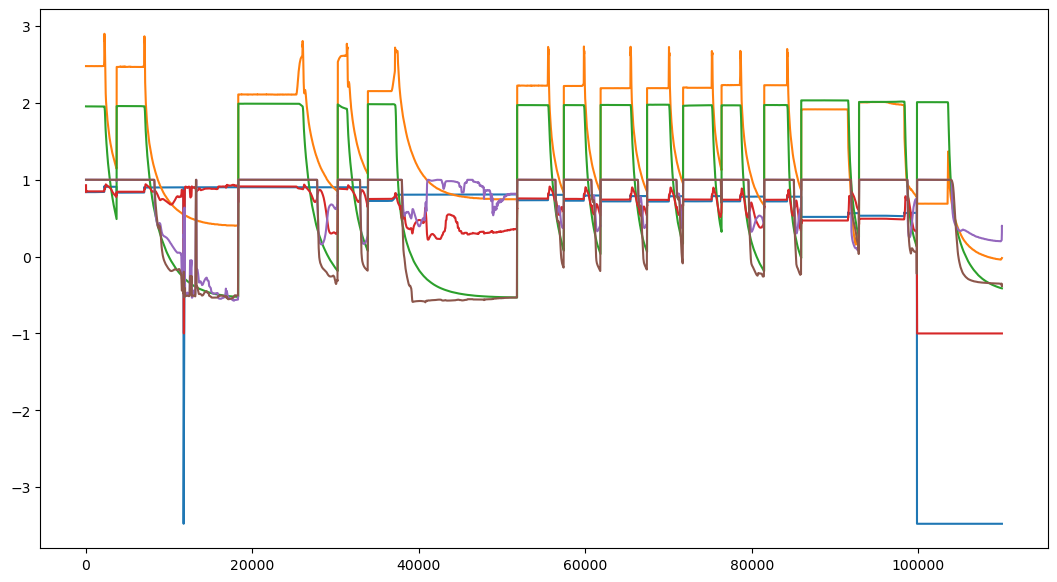

In [42]:
plt.figure(figsize=(13,7))
plt.plot(merged_data_test_np_scaled)
plt.plot(fake_data_2d)
plt.show()

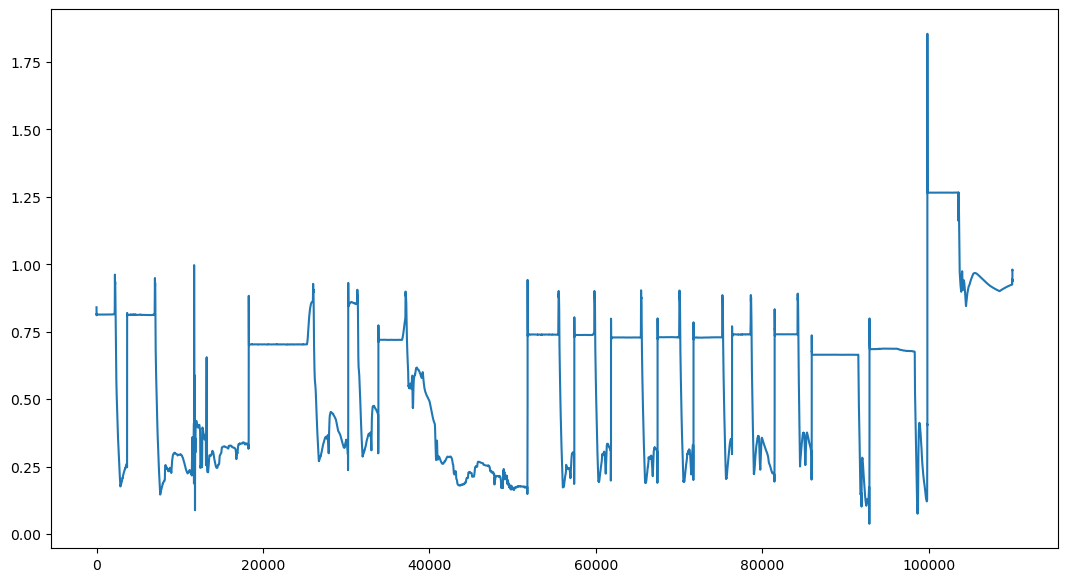

In [38]:
r_e = calculate_reconstruction_loss(merged_data_test_np_scaled, fake_data_2d)
plt.figure(figsize=(13,7))
# plt.plot(merged_data_test_np_scaled)
plt.plot(r_e)
plt.show()

In [49]:
thres, f1 = find_optimal_threshold(r_e, merged_data_test_class)

In [50]:
print(thres, f1)

0.6626626626626626 0.9085184081085109


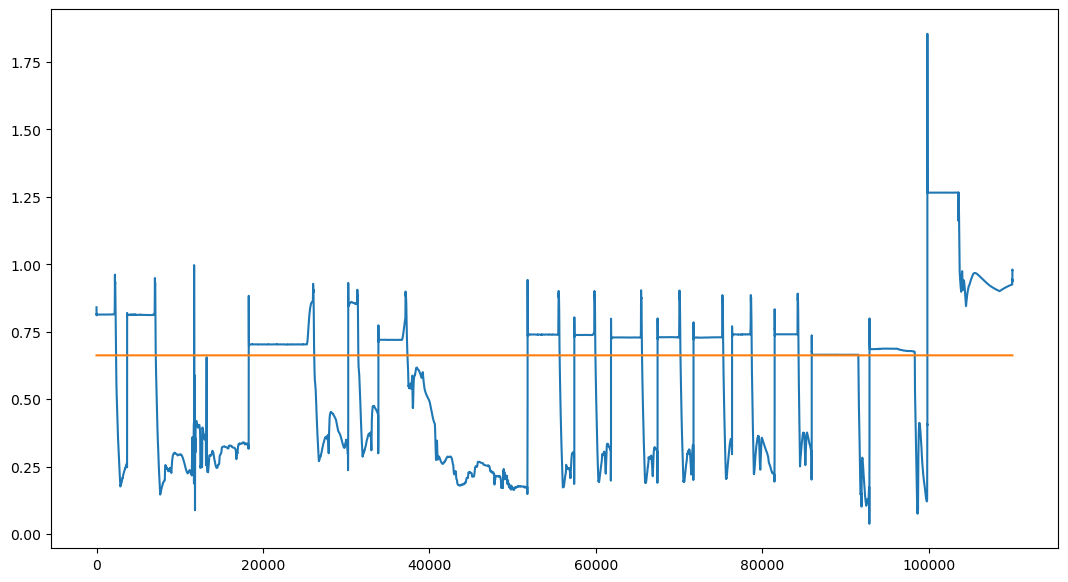

In [51]:
plt.figure(figsize=(13,7))
plt.plot(r_e)
plt.plot(np.full(len(r_e),thres))
plt.show()